In [ ]:
!wget https://www.lamsade.dauphine.fr/~cazenave/project2026.zip
!unzip project2026.zip
!ls -l

--2026-01-19 07:25:42--  https://www.lamsade.dauphine.fr/~cazenave/project2026.zip
Resolving www.lamsade.dauphine.fr (www.lamsade.dauphine.fr)... 193.48.71.250
Connecting to www.lamsade.dauphine.fr (www.lamsade.dauphine.fr)|193.48.71.250|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 138578548 (132M) [application/zip]
Saving to: ‘project2026.zip’

project2026.zip     100%[===================>] 132.16M  23.0MB/s    in 6.6s    

2026-01-19 07:25:50 (20.0 MB/s) - ‘project2026.zip’ saved [138578548/138578548]

Archive:  project2026.zip
  inflating: games.data              
  inflating: golois.cpython-312-x86_64-linux-gnu.so  
total 665408
-rw-r--r-- 1 root root 542497580 Oct  7  2022 games.data
-rwxr-xr-x 1 root root    284672 Oct  1 15:09 golois.cpython-312-x86_64-linux-gnu.so
-rw-r--r-- 1 root root 138578548 Oct  1 20:02 project2026.zip
drwxr-xr-x 1 root root      4096 Dec  9 14:42 sample_data


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tensorflow

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras import regularizers
import gc
import matplotlib.pyplot as plt
import pandas as pd
import golois

planes = 31
moves = 361
N = 50000
epochs = 1000 # at least
batch = 128
filters = 32

input_data = np.random.randint(2, size=(N, 19, 19, planes))
input_data = input_data.astype ('float32')

In [ ]:
policy = np.random.randint(moves, size=(N,))
policy = keras.utils.to_categorical (policy)
policy = policy.astype ('float32')

value = np.random.randint(2, size=(N,))
value = value.astype ('float32')

end = np.random.randint(2, size=(N, 19, 19, 2))
end = end.astype ('float32')

groups = np.zeros((N, 19, 19, 1))
groups = groups.astype ('float32')

print ("Tensorflow version", tf.__version__)
print ("getValidation", flush = True)
golois.getValidation (input_data, policy, value, end)

Tensorflow version 2.19.0
getValidation


In [ ]:
# Define checkpoint directory (persistent on Drive)
import os
import json
checkpoint_dir = "/content/drive/MyDrive/Complex_mobile_net/checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

checkpoint_path = os.path.join(checkpoint_dir, "model_last.keras")
progress_file = os.path.join(checkpoint_dir, "progress.json")
metrics_path = "/content/drive/MyDrive/Complex_mobile_net/training_metrics.csv"


progress_file = "/content/drive/MyDrive/Complex_mobile_net/checkpoints/progress.json"
if os.path.exists(progress_file):
    !cat {progress_file}
else:
    print(f"File not found: {progress_file}")

# Metrics saving
# Initialize metrics storage
if os.path.exists(metrics_path):
    metrics_df = pd.read_csv(metrics_path)
else:
    metrics_df = pd.DataFrame(columns=[
        "epoch",
        "train_policy_loss", "train_value_loss",
        "train_policy_acc", "train_value_mae",
        "val_policy_loss", "val_value_loss",
        "val_policy_acc", "val_value_mae"
    ])

print("\n Metrics of last epochs")
metrics_df

{"last_epoch": 4561}
 Metrics of last epochs


,epoch,train_policy_loss,train_value_loss,train_policy_acc,train_value_mae,val_policy_loss,val_value_loss,val_policy_acc,val_value_mae
0,20.0,2.523351,0.119647,0.36702,0.291662,2.533167,0.120234,0.36960,0.292529
1,40.0,2.366110,0.120268,0.38940,0.292626,2.393825,0.120233,0.38730,0.292516
2,60.0,2.272054,0.120540,0.40330,0.293269,2.290629,0.120233,0.40066,0.292519
3,80.0,2.227778,0.119173,0.40958,0.290895,2.247118,0.120251,0.40854,0.292550
4,100.0,2.174410,0.119335,0.41572,0.291051,2.212980,0.120233,0.40990,0.292521
...,...,...,...,...,...,...,...,...,...
222,4460.0,1.853487,0.119857,0.47482,0.292013,1.851159,0.120235,0.47538,0.292509
223,4480.0,1.851271,0.120682,0.47458,0.293133,1.855879,0.120256,0.47576,0.292559
224,4500.0,1.839616,0.120423,0.47610,0.292814,1.848560,0.120233,0.47776,0.292517
225,4520.0,1.838264,0.120316,0.47590,0.293002,1.853427,0.120235,0.47380,0.292507


In [ ]:
def inverted_residual_block(x, expansion_factor, out_channels, stride=1, use_residual=True):
    """
    MobileNetV2-style inverted residual block
    - Expands channels with 1x1 conv
    - Depthwise conv in expanded space
    - Projects back down with 1x1 conv
    """
    in_channels = x.shape[-1]
    expanded_channels = in_channels * expansion_factor

    # Expansion phase
    if expansion_factor != 1:
        expand = layers.Conv2D(expanded_channels, 1, padding='same', use_bias=False)(x)
        expand = layers.BatchNormalization()(expand)
        expand = layers.Activation('relu')(expand)
    else:
        expand = x

    # Depthwise convolution
    depthwise = layers.DepthwiseConv2D(3, strides=stride, padding='same', use_bias=False)(expand)
    depthwise = layers.BatchNormalization()(depthwise)
    depthwise = layers.Activation('relu')(depthwise)

    # Projection phase (linear)
    project = layers.Conv2D(out_channels, 1, padding='same', use_bias=False)(depthwise)
    project = layers.BatchNormalization()(project)

    # Residual connection
    if use_residual and stride == 1 and in_channels == out_channels:
        return layers.Add()([x, project])
    return project

def efficient_attention_block(x, channels):
    """
    Lightweight spatial attention mechanism
    Helps the network focus on important board regions
    """
    # Channel attention (squeeze-excitation style)
    squeeze = layers.GlobalAveragePooling2D()(x)
    excite = layers.Dense(channels // 4, activation='relu')(squeeze)
    excite = layers.Dense(channels, activation='sigmoid')(excite)
    excite = layers.Reshape((1, 1, channels))(excite)
    return layers.Multiply()([x, excite])

def build_mobilenet_go_model_deep(filters=28):
    """
    Enhanced MobileNet-inspired architecture for Go
    Deeper version with more inverted residual blocks and attention mechanisms
    Target: ~90-95K parameters (under 100K limit)

    Architecture improvements:
    1. More stages with careful channel management
    2. Multiple attention blocks at different depths
    3. Deeper inverted residual block chains
    4. Enhanced feature extraction while staying under 100K params
    """
    input_layer = keras.Input(shape=(19, 19, planes), name='board')

    # Initial convolution - establish base features
    x = layers.Conv2D(filters, 3, padding='same', use_bias=False)(input_layer)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # Stage 1: t=2, k=3, c=28, n=3 (increased from 2)
    x = inverted_residual_block(x, expansion_factor=2, out_channels=filters)
    x = inverted_residual_block(x, expansion_factor=2, out_channels=filters)
    x = inverted_residual_block(x, expansion_factor=2, out_channels=filters)

    # First attention - early feature refinement
    x = efficient_attention_block(x, filters)

    # Stage 2: t=3, k=3, c=36, n=3
    x = inverted_residual_block(x, expansion_factor=3, out_channels=filters + 8)
    x = inverted_residual_block(x, expansion_factor=3, out_channels=filters + 8)
    x = inverted_residual_block(x, expansion_factor=3, out_channels=filters + 8)

    # Second attention - mid-level feature focus
    x = efficient_attention_block(x, filters + 8)

    # Stage 3: t=3, k=3, c=40, n=3
    x = inverted_residual_block(x, expansion_factor=3, out_channels=filters + 12)
    x = inverted_residual_block(x, expansion_factor=3, out_channels=filters + 12)
    x = inverted_residual_block(x, expansion_factor=3, out_channels=filters + 12)

    # Third attention - high-level feature refinement
    x = efficient_attention_block(x, filters + 12)

    # Final feature refinement
    x = layers.Conv2D(filters + 16, 1, padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    # ========== POLICY HEAD ==========
    # Enhanced policy head
    policy = layers.SeparableConv2D(20, 3, padding='same', use_bias=False)(x)
    policy = layers.BatchNormalization()(policy)
    policy = layers.Activation('relu')(policy)

    policy = layers.Conv2D(3, 1, padding='same', use_bias=False)(policy)
    policy = layers.BatchNormalization()(policy)
    policy = layers.Activation('relu')(policy)

    policy = layers.Conv2D(1, 1, padding='same', use_bias=False,
                          kernel_regularizer=regularizers.l2(0.0001))(policy)
    policy = layers.Flatten()(policy)
    policy = layers.Activation('softmax', name='policy')(policy)

    # ========== VALUE HEAD ==========
    # Enhanced value head
    value = layers.Conv2D(12, 1, padding='same', use_bias=False)(x)
    value = layers.BatchNormalization()(value)
    value = layers.Activation('relu')(value)

    # Global average pooling
    value = layers.GlobalAveragePooling2D()(value)

    # Deeper dense layers
    value = layers.Dense(48, activation='relu',
                        kernel_regularizer=regularizers.l2(0.001))(value)
    value = layers.Dropout(0.3)(value)
    value = layers.Dense(24, activation='relu',
                        kernel_regularizer=regularizers.l2(0.001))(value)
    value = layers.Dropout(0.3)(value)
    value = layers.Dense(1, activation='sigmoid', name='value',
                        kernel_regularizer=regularizers.l2(0.0001))(value)

    model = keras.Model(inputs=input_layer, outputs=[policy, value])
    return model

# Build and display enhanced model
print("=" * 60)
print("ENHANCED MOBILENET GO MODEL (Under 100K params)")
print("=" * 60)
model = build_mobilenet_go_model_deep(filters=28)
model.summary()

# Compile model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss={'policy': 'categorical_crossentropy', 'value': 'mse'},
    loss_weights={'policy': 1.0, 'value': 1.0},
    metrics={'policy': 'categorical_accuracy', 'value': 'mae'}
)

In [ ]:
# resume if previous checkpoint exists
start_epoch = 0
if os.path.exists(checkpoint_path) and os.path.exists(progress_file):
    print("Loading model from checkpoint...")
    model = keras.models.load_model(checkpoint_path)
    with open(progress_file, "r") as f:
        start_epoch = json.load(f)["last_epoch"]
    print(f"Resuming from epoch {start_epoch + 1}")
else:
    print("Starting training from scratch")

# training
for i in range(start_epoch + 1, start_epoch + epochs + 1):
    print('epoch ' + str (i))
    golois.getBatch (input_data, policy, value, end, groups, i * N)
    # data augmentation
    # todo
    history = model.fit(input_data,
                        [policy,value],
                        epochs=1, batch_size=batch)
    # save JSON progress every epoch (lightweight)
    with open(progress_file, "w") as f:
        json.dump({"last_epoch": i}, f)

    # Get training metrics
    train_metrics = history.history
    train_policy_loss = train_metrics['policy_loss'][-1]
    train_value_loss = train_metrics['value_loss'][-1]
    train_policy_acc = train_metrics['policy_categorical_accuracy'][-1]
    train_value_mae = train_metrics['value_mae'][-1]

    if (i % 5 == 0):
        gc.collect ()
    # Save progress every 20 epochs
    if (i % 20 == 0):
        golois.getValidation (input_data, policy, value, end)
        val = model.evaluate (input_data,
                              [policy, value], verbose = 0, batch_size=batch)

        val_policy_loss = val[1]
        val_value_loss = val[2]
        val_policy_acc = val[3]
        val_value_mae = val[4]
        print("val =", val)
        # save model + progress
        model.save(checkpoint_path)
        print(f"Saved checkpoint at epoch {i}")
        # Append metrics to dataframe
        metrics_df.loc[len(metrics_df)] = [
            i,
            train_policy_loss, train_value_loss,
            train_policy_acc, train_value_mae,
            val_policy_loss, val_value_loss,
            val_policy_acc, val_value_mae
        ]

        # Save metrics file
        metrics_df.to_csv(metrics_path, index=False)

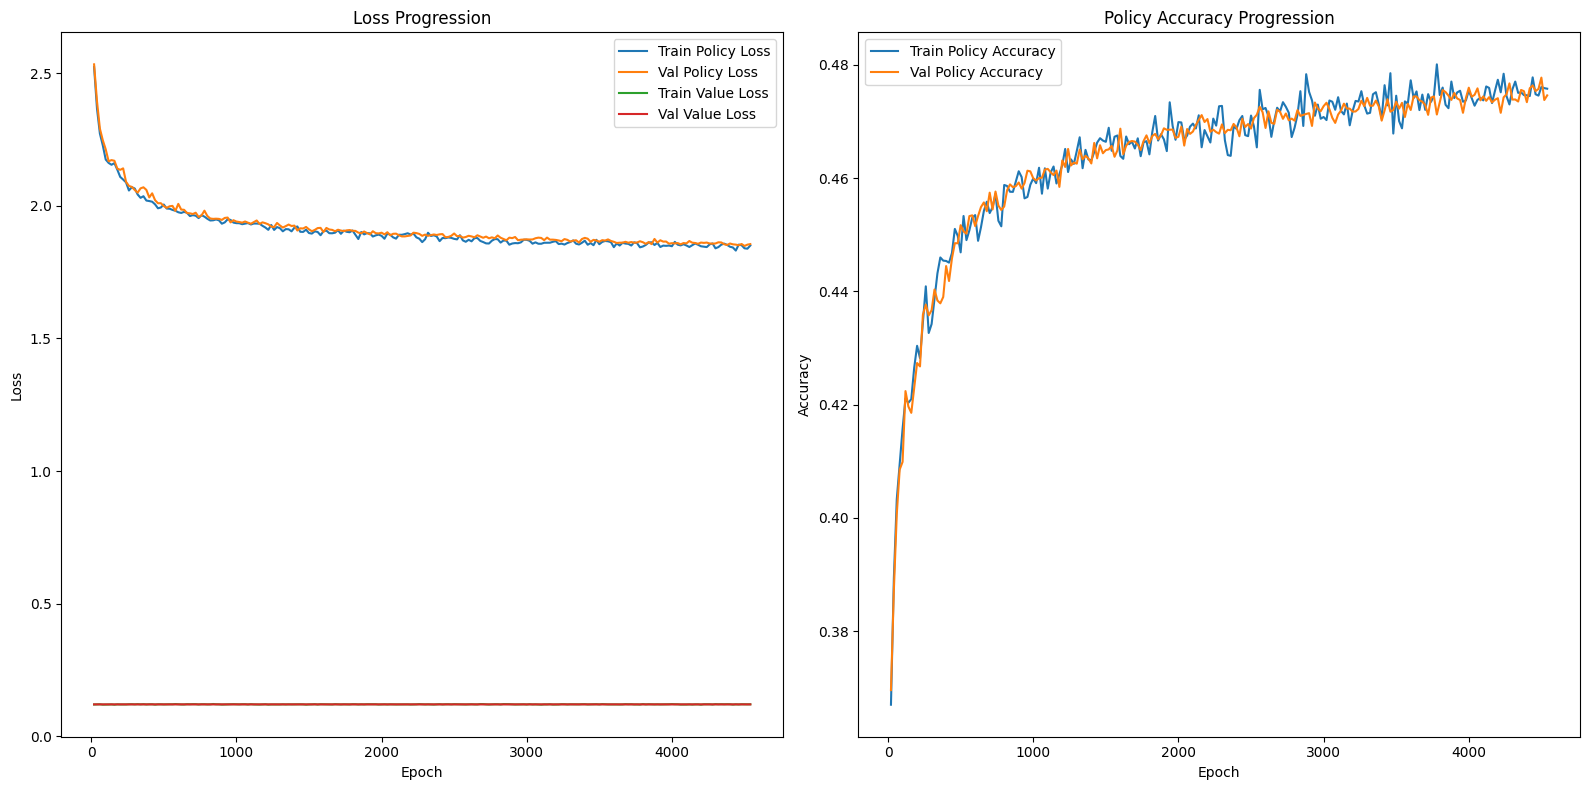

In [ ]:
# Reload metrics
metrics_df = pd.read_csv(metrics_path)

plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plt.plot(metrics_df["epoch"], metrics_df["train_policy_loss"], label="Train Policy Loss")
plt.plot(metrics_df["epoch"], metrics_df["val_policy_loss"], label="Val Policy Loss")
plt.plot(metrics_df["epoch"], metrics_df["train_value_loss"], label="Train Value Loss")
plt.plot(metrics_df["epoch"], metrics_df["val_value_loss"], label="Val Value Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Progression")
plt.legend()

plt.subplot(1,2,2)
plt.plot(metrics_df["epoch"], metrics_df["train_policy_acc"], label="Train Policy Accuracy")
plt.plot(metrics_df["epoch"], metrics_df["val_policy_acc"], label="Val Policy Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Policy Accuracy Progression")
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
matching_rows = metrics_df[metrics_df['val_policy_acc'].astype(str).str.startswith('0.46')]
if not matching_rows.empty:
    first_matching_row = matching_rows.iloc[0]
    print("First row where 'val_policy_acc' starts with '0.46':")
    print(first_matching_row)
else:
    print("No row found where 'val_policy_acc' starts with '0.46'.")

First row where 'val_policy_acc' starts with '0.46':
epoch                960.000000
train_policy_loss      1.946654
train_value_loss       0.120703
train_policy_acc       0.456680
train_value_mae        0.293537
val_policy_loss        1.937275
val_value_loss         0.120234
val_policy_acc         0.461320
val_value_mae          0.292530
Name: 47, dtype: float64


In [ ]:
max_val_policy_acc_row = metrics_df.loc[metrics_df['val_policy_acc'].idxmax()]
print("Row with the maximum 'val_policy_acc':")
print(max_val_policy_acc_row)

Row with the maximum 'val_policy_acc':
epoch                4500.000000
train_policy_loss       1.839616
train_value_loss        0.120423
train_policy_acc        0.476100
train_value_mae         0.292814
val_policy_loss         1.848560
val_value_loss          0.120233
val_policy_acc          0.477760
val_value_mae           0.292517
Name: 224, dtype: float64


In [ ]:
checkpoint_dir = "/content/drive/MyDrive/Complex_mobile_net/checkpoints"
model = keras.models.load_model(os.path.join(checkpoint_dir, "model_last_4763.keras"))
model.save('Mellissa_HAFIS-Ilona_LEDROGOFF_MobileNet-Winner.h5')